In [2]:
import pandas as pd
from pandas_ods_reader import read_ods
import seaborn as sn
import matplotlib.pyplot as plt
import tqdm
import os
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

### This file is used to find correlation between Net biome productivity, soil organic carbon, ecosystem co2 and the rest of the properties


#### Measured using Pearson's coefficient

#### Target dict contains the target variables from each file 

In [3]:
target = 'NEE'

model = ['rcef_RandomForestRegressor', 'rcef_RidgeCV', 'rcef_XGBRegressor', 'xgboost'] 

extracted_features = model[-1]

In [4]:
# loads all data sets into a dict
def load_datasets(dirs: list, load_path: str) -> dict:
    files = ['soil_c','surf_water','flux_soc','soil_water','n_flux','p_flux','temp', 
         'plant_c','plant_n','plant_p','canopcy_c','plant_stress','photosynthesis','plant_growth']
    
    #files.append('soil_temp', 'canopy_temp') missing 
    datasets = {}
    
    for dr in dirs:
        csv_list = []
        path = 'datasets/' + dr + load_path
        for f in files:
            df = pd.read_csv(os.path.join(path,f + '.csv'))
            df.drop(df.columns[0], axis=1)

            csv_list.append(df)


        data_dict = {}
        for i in range (len(csv_list)):
            data_dict[files[i]] = csv_list[i]

        datasets[dr] = data_dict

    return datasets

dirs = ['warm_temp_maize_soybean_irrigated', 'warm_temp_maize-soybean_dryland', 'cool_temp_maize_soybean']

datasets = load_datasets(dirs, '/csv_outs/with_plant_soil_details/')

In [5]:
def rename_dupes(suffix: str, df: pd.DataFrame, dupes: list) -> pd.DataFrame:
    for col in df.columns:
        if col in dupes:
            df.rename(columns={col: col + suffix}, inplace=True)
    return df


mdays=[31,28,31,30,31,30,31,31,30,31,30,31]

def isleap(year):
    leap=False
    if year % 4 == 0 and year % 100 != 0:
        leap=True
    elif year % 100 == 0:
        leap=False
    elif year % 400 ==0:
        leap=True
    else:
        leap=False
    return leap
def dayofyear(year,month,day):
    doy=0
    for mm in range(0,month):
        days=mdays[mm]
        if mm==1:
            if isleap(year):
                days=29
        for dd in range(0,days):
            if mm < month-1:
                doy=doy+1
            else:
                if dd < day:
                    doy=doy+1
    return doy

def average_numbered_columns(df):
    numbered_cols = [col for col in df.columns if '_' in col and col.split('_')[-1].isdigit()]

    col_groups = {}
    for col in numbered_cols:
        prefix = '_'.join(col.split('_')[:-1])
        if prefix not in col_groups:
            col_groups[prefix] = []
        col_groups[prefix].append(col)

    # calculate averages and add new columns
    for prefix, cols in col_groups.items():
        avg_col_name = prefix
        avg_col_values = df[cols].mean(axis=1)
        df[avg_col_name] = avg_col_values

    # drop numbered columns
    df = df.drop(columns=numbered_cols)

    return df

def nee_cumulative_to_daily(df: pd.DataFrame) -> pd.DataFrame:
    df['DOY'] = df['DOY'].astype(int)

    # Divide only rows with DOY > 0
    df['ECO_NPP'] = df.apply(lambda row: row['ECO_NPP']/row['DOY'] if row['DOY'] != 0 else row['ECO_NPP'], axis=1)
    df['ECO_RH'] = df.apply(lambda row: row['ECO_RH']/row['DOY'] if row['DOY'] != 0 else row['ECO_RH'], axis=1)

    df['NEE'] = df['ECO_NPP'] - df['ECO_RH']
    
    return df

# turn all csv's to one dataframe
def to_pd(df: dict, handle_dupes: bool, flatten_num_cols: bool) -> pd.DataFrame:
    x = pd.DataFrame()
    for file_name in df:
        cur = df[file_name]
            
        x = pd.concat([x, df[file_name]], axis = 1)
        
    cheeky_col = 'unnamed.1'
    cheeky_col2 = 'Unnamed: 0'
    if cheeky_col in x.columns:
        x = x.drop([cheeky_col], axis=1)
    elif cheeky_col2 in x.columns:
         x = x.drop([cheeky_col2], axis=1)

    if flatten_num_cols:
        x = average_numbered_columns(x)
        
    x = x.loc[:,~x.columns.duplicated()].copy()
    
    one_hot = pd.get_dummies(x['GROWTH_STG'])
    x= x.drop('GROWTH_STG',axis = 1)
    # Join the encoded df
    x = x.join(one_hot)
    
    x['WIND'] = x['WIND'] / 100
    
    x['DATE'] =  pd.to_datetime(x['DATE'])
    
    x['DOY'] = 0
    for i in range( x.shape[0]):
        x['DOY'][i] = dayofyear(x['DATE'][i].year, x['DATE'][i].month, x['DATE'][i].day)
    

    x.columns = x.columns.str.translate("".maketrans({"[":"{", "]":"}","<":"^"}))
    
    return x

df_dry = nee_cumulative_to_daily(to_pd(datasets['warm_temp_maize-soybean_dryland'], True, True))
df_irr = nee_cumulative_to_daily(to_pd(datasets['warm_temp_maize_soybean_irrigated'], True, True))
df_cool = nee_cumulative_to_daily(to_pd(datasets['cool_temp_maize_soybean'], True, True))

df = pd.concat([df_dry,df_irr, df_cool])

y = df[target].copy()

#y = df[target].copy()
#df = df.drop(target, axis=1)

In [10]:
# no GPT / copilot baby
def get_correlations(data: dict, file_name: str, target_vars: list, threshold: int ) -> dict:
    corr_dict = {}
    for target_var in target_vars:
        corr = pd.Series([])
        target_data = data[target_var]
        
        for file in data:
            df = data[file]
            
            if target_var not in df.columns:
                df[target_var] = target_data
                
            c = df.corr()[target_var]
            c = c[abs(c) > threshold]
            c = c.where(c.index != target_var).dropna()
            corr = pd.concat([corr, c])
        
        corr = corr.sort_values(ascending=False)
        corr_dict[target_var] = corr
    
    return corr_dict     

In [51]:
cors = df.corr()['NEE'].sort_values(ascending=False).dropna().drop(['NEE', 'ECO_NPP', 'NPP', 'ECO_GPP', 'GPP', 'CAN_GPP'])

cors = cors[cors.abs() > 0.84] 

In [52]:
cors

UPTK_N           0.913617
D_ET             0.912239
D_TRANSPN        0.896359
D_PRECN          0.890435
D_NH3_FLUX       0.889435
D_O2_FLUX        0.873669
NET_N_MIN        0.869951
NODE_NO.         0.864529
CO2_FLUX        -0.850166
NET_PL_EXCH_N   -0.868318
D_AUTO_RESP     -0.890623
ECO_RA          -0.890623
CAN_RA          -0.894968
ABV_GRD_RESP    -0.896393
Name: NEE, dtype: float64

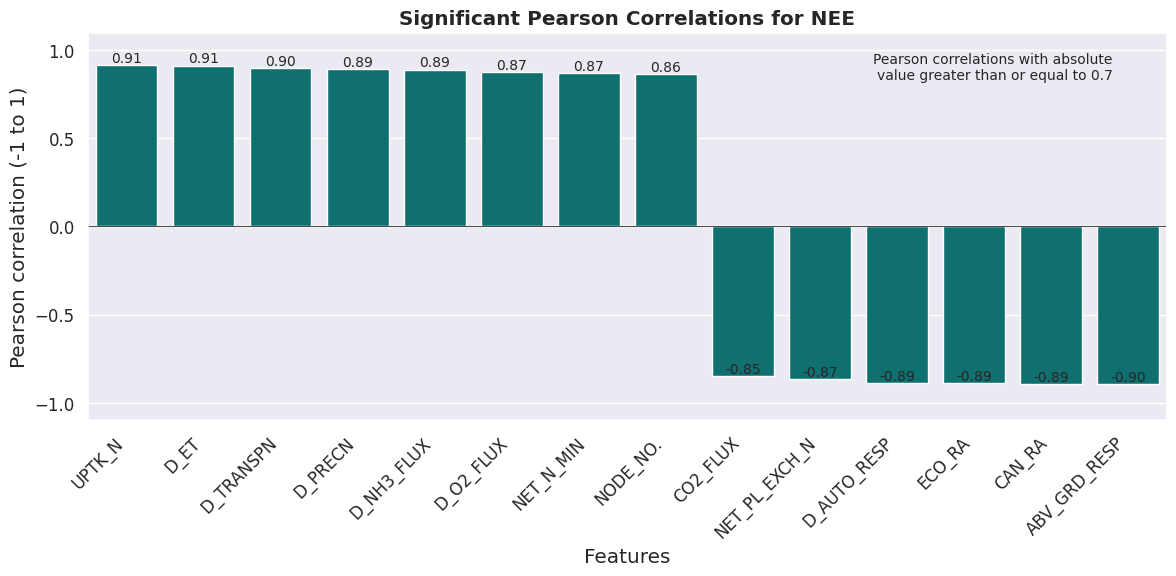

In [56]:
sns.set_style('whitegrid')

plt.figure(figsize=(12, 6))
sns.set(font_scale=1.2)

sns.barplot(x=cors.index, y=cors, color='teal')


plt.xlabel('Features')
plt.ylabel('Pearson correlation (-1 to 1)')
plt.title('Significant Pearson Correlations for ' + cors.name, fontweight='bold')


plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks([-1, -0.5, 0, 0.5, 1], fontsize=12)
plt.ylim(-1.1, 1.1)


plt.axhline(0, color='black', linewidth=0.5)


for i, v in enumerate(cors):
    if abs(v) >= 0.7:
        plt.annotate(f"{v:.2f}", xy=(i, v), ha='center', va='bottom', fontsize=10)


plt.text(0.95, 0.95, "Pearson correlations with absolute\nvalue greater than or equal to 0.7", 
         ha='right', va='top', transform=plt.gca().transAxes, fontsize=10)

plt.tight_layout()
plt.show()